# **Task1**


Using Pre-Trained ResNet18 for EMNIST...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


Training with lr=0.001, batch_size=32, num_layers=1...
Epoch 1: Train Loss=1.4836, Train Accuracy=55.14%, Validation Loss=0.6332, Validation Accuracy=79.03%
Epoch 2: Train Loss=1.0256, Train Accuracy=67.21%, Validation Loss=0.5657, Validation Accuracy=80.93%
Epoch 3: Train Loss=0.9173, Train Accuracy=70.24%, Validation Loss=0.5281, Validation Accuracy=82.49%
Epoch 4: Train Loss=0.8543, Train Accuracy=72.12%, Validation Loss=0.5089, Validation Accuracy=82.55%
Epoch 5: Train Loss=0.7964, Train Accuracy=74.22%, Validation Loss=0.4833, Validation Accuracy=83.48%
Epoch 6: Train Loss=0.7487, Train Accuracy=75.22%, Validation Loss=0.4769, Validation Accuracy=83.74%
Epoch 7: Train Loss=0.7184, Train Accuracy=76.36%, Validation Loss=0.4807, Validation Accuracy=83.94%
Epoch 8: Train Loss=0.6823, Train Accuracy=77.30%, Validation Loss=0.4597, Validation Accuracy=84.58%
Epoch 9: Train Loss=0.6539, Train Accuracy=78.24%, Validation Loss=0.4506, Validation Accuracy=84.79%
Epoch 10: Train Loss=0.6263

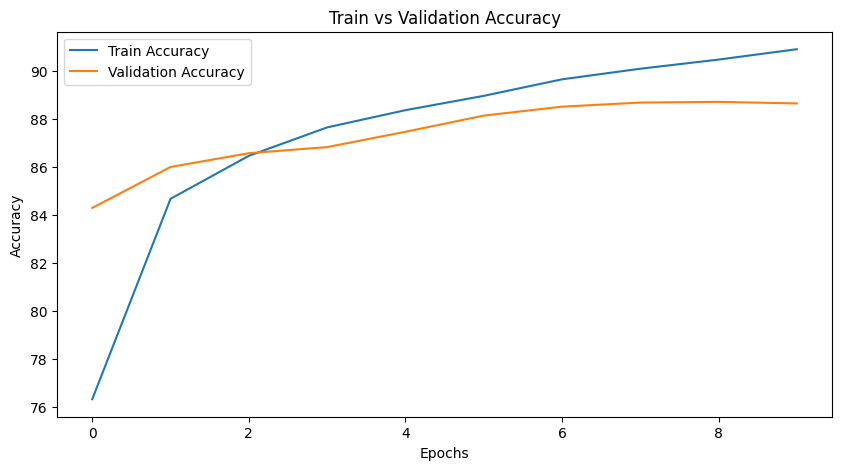

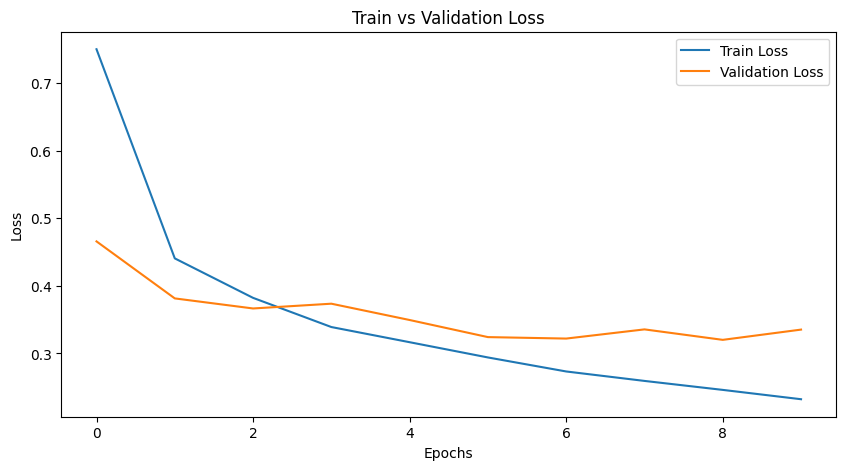

Total Training Time: 307.42 seconds

Best Hyperparameters:
   Learning Rate  Batch Size  Number of Layers
0         0.0005          64                 2


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Load and Process the Characters Dataset
class CharacterDataset(Dataset):
    def __init__(self, csv_file, mapping_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        if self.data.isnull().values.any():
            print("Warning: Missing values found. Filling missing values.")
            self.data = self.data.fillna(0)
        self.labels = self.data.iloc[:, 0].values
        self.pixels = self.data.iloc[:, 1:].values
        self.pixels = np.nan_to_num(self.pixels, nan=0.0, posinf=1.0, neginf=0.0) / 255.0
        self.pixels = self.pixels.reshape(-1, 28, 28)
        self.pixels = np.clip(self.pixels, 0, 1)
        self.mapping = {}
        with open(mapping_file, 'r') as f:
            for line in f:
                index, ascii_code = line.strip().split()
                self.mapping[int(index)] = chr(int(ascii_code))
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.pixels[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label

# Data augmentation techniques
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# File paths
train_csv = '/content/drive/MyDrive/Colab Notebooks/Dataset/characters.csv'
test_csv = '/content/drive/MyDrive/Colab Notebooks/Dataset/characters-test.csv'
mapping_file = '/content/drive/MyDrive/Colab Notebooks/Dataset/mapping.txt'

# Create dataset
dataset = CharacterDataset(train_csv, mapping_file, transform=data_transforms)

# Split the data into training, validation, and test sets (70% train, 15% val, 15% test)
train_pixels, test_pixels, train_labels, test_labels = train_test_split(
    dataset.pixels, dataset.labels, test_size=0.3, random_state=42
)
val_pixels, test_pixels, val_labels, test_labels = train_test_split(
    test_pixels, test_labels, test_size=0.5, random_state=42
)

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(train_pixels, dtype=torch.float32).unsqueeze(1),
                                    torch.tensor(train_labels, dtype=torch.long)),
    batch_size=64, shuffle=True
)

val_loader = DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(val_pixels, dtype=torch.float32).unsqueeze(1),
                                    torch.tensor(val_labels, dtype=torch.long)),
    batch_size=64, shuffle=False
)

# Step 3: Model Architecture (Custom CNN for Characters Dataset)
class CharacterCNN(nn.Module):
    def __init__(self, num_layers=3):
        super(CharacterCNN, self).__init__()
        self.num_layers = num_layers
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()

        # Initialize the input/output channels
        in_channels = 1
        out_channels = 32

        # Add the convolutional and batch normalization layers
        for _ in range(num_layers):
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            self.bn_layers.append(nn.BatchNorm2d(out_channels))
            in_channels = out_channels
            out_channels *= 2  # Double the number of channels with each layer

        # Calculate the output size after convolutions and pooling
        self.pool = nn.MaxPool2d(2, 2)
        self.dummy_input = torch.zeros(1, 1, 28, 28)  # Dummy input to calculate output size
        self._calculate_flattened_size()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, len(dataset.mapping))  # Change this if needed
        self.dropout = nn.Dropout(0.5)

    def _calculate_flattened_size(self):
        # Pass a dummy input through the convolutional layers and pooling to get the flattened size
        x = self.dummy_input
        for i in range(self.num_layers):
            x = self.pool(torch.relu(self.bn_layers[i](self.conv_layers[i](x))))
        self.flattened_size = x.view(1, -1).size(1)  # Flatten and get the size of the flattened tensor

    def forward(self, x):
        for i in range(self.num_layers):
            x = self.pool(torch.relu(self.bn_layers[i](self.conv_layers[i](x))))
        x = x.view(x.size(0), -1)  # Flattening
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Step 4: Pre-Trained EMNIST Model
print("\nUsing Pre-Trained ResNet18 for EMNIST...")
emnist_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
emnist_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
emnist_model.fc = nn.Linear(emnist_model.fc.in_features, len(dataset.mapping))
emnist_model = emnist_model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(emnist_model.parameters(), lr=0.0005)

# Step 6: Early Stopping Implementation
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Hyperparameter tuning function to experiment with different configurations
def hyperparameter_tuning():
    learning_rates = [0.001, 0.0005, 0.00008]
    batch_sizes = [32, 64, 128]
    num_layers_list = [1, 2]
    best_acc = 0
    best_params = None
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for num_layers in num_layers_list:
                print(f"Training with lr={lr}, batch_size={batch_size}, num_layers={num_layers}...")
                emnist_model = CharacterCNN(num_layers=num_layers).to(device)
                optimizer = optim.AdamW(emnist_model.parameters(), lr=lr)
                train_loader = DataLoader(
                    torch.utils.data.TensorDataset(torch.tensor(train_pixels, dtype=torch.float32).unsqueeze(1),
                                                    torch.tensor(train_labels, dtype=torch.long)),
                    batch_size=batch_size, shuffle=True
                )
                val_loader = DataLoader(
                    torch.utils.data.TensorDataset(torch.tensor(val_pixels, dtype=torch.float32).unsqueeze(1),
                                                    torch.tensor(val_labels, dtype=torch.long)),
                    batch_size=batch_size, shuffle=False
                )

                early_stopping = EarlyStopping(patience=3, delta=0.01)
                for epoch in range(10):  # Shorter training for tuning
                    train_loss, train_acc = train(emnist_model, train_loader, optimizer, criterion, device)
                    val_loss, val_acc = validate(emnist_model, val_loader, criterion, device)
                    early_stopping(val_loss)

                    # Print the results after each epoch
                    print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Train Accuracy={train_acc:.2f}%, "
                          f"Validation Loss={val_loss:.4f}, Validation Accuracy={val_acc:.2f}%")

                    if early_stopping.early_stop:
                        print("Early stopping triggered.")
                        break
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_params = (lr, batch_size, num_layers)

    print(f"Best Parameters: lr={best_params[0]}, batch_size={best_params[1]}, num_layers={best_params[2]}")
    return best_params

# Step 7: Training and Validation Functions
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        if torch.isnan(loss) or torch.isinf(loss):
            print("Skipping batch due to NaN or Infinite loss.")
            continue
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss / len(train_loader), accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    accuracy = 100. * correct / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy

def test(model, test_loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []  # حفظ التنبؤات والتسميات
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())  # إضافة التنبؤات
            all_labels.extend(labels.cpu().numpy())  # إضافة التسميات
    accuracy = 100. * correct / len(test_loader.dataset)

    # حساب الدقة، الاسترجاع، F1، والدقة الحقيقية
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return total_loss / len(test_loader), accuracy, precision, recall, f1

# Step 8: Training Loop with Early Stopping and Timing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emnist_model = emnist_model.to(device)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

# Get the best hyperparameters
best_params = hyperparameter_tuning()  # Get best hyperparameters
learning_rate, batch_size, num_layers = best_params  # Correct unpacking

optimizer = optim.AdamW(emnist_model.parameters(), lr=learning_rate)
train_loader = DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(train_pixels, dtype=torch.float32).unsqueeze(1),
                                    torch.tensor(train_labels, dtype=torch.long)),
    batch_size=batch_size, shuffle=True
)

# Training with Early Stopping and Hyperparameters Tuning
early_stopping = EarlyStopping(patience=5, delta=0.01)
start_time = time.time()

for epoch in range(10):  # Number of epochs
    train_loss, train_accuracy = train(emnist_model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate(emnist_model, val_loader, criterion, device)
    early_stopping(val_loss)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Step 9: Test the Model
test_dataset = CharacterDataset(test_csv, mapping_file, transform=None)

# Create DataLoader for test set
test_loader = DataLoader(
    test_dataset,
    batch_size =64, shuffle=False
)

test_loss, test_accuracy, precision, recall, f1 = test(emnist_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, "
      f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Step 10: Plot Training and Validation Curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

# Print the total training time
end_time = time.time()
print(f"Total Training Time: {end_time - start_time:.2f} seconds")

# Display the best hyperparameters in a table format
import pandas as pd

best_hyperparams = {
    "Learning Rate": [best_params[0]],
    "Batch Size": [best_params[1]],
    "Number of Layers": [best_params[2]]
}

best_hyperparams_df = pd.DataFrame(best_hyperparams)
print("\nBest Hyperparameters:")
print(best_hyperparams_df)